In [8]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import unicodedata
from pathlib import Path

In [2]:
# LOAD CIRCUIT GEOMETRY UNIQUE

circuit_geometry = pd.read_csv('csv_output/Circuit_geometry_unique.csv')

print("Circuit Geometry Dataset")
print(f"Shape: {circuit_geometry.shape}")
print(f"Columns: {circuit_geometry.columns.tolist()}")
print(f"Unique circuits: {circuit_geometry['circuitRef'].nunique()}")


# LOAD COMBINED LAP TIMING CLEAN

lap_timing = pd.read_excel('csv_output/Combined_Lap_Timing_Final.xlsx')

print(f"\nCombined Lap Timing Final Dataset")

print(f"Shape: {lap_timing.shape}")
print(f"Columns: {lap_timing.columns.tolist()}")
print(f"Total Rows: {len(lap_timing)}")



Circuit Geometry Dataset
Shape: (24, 28)
Columns: ['circuitRef', 'year', 'round', 'name', 'type', 'num_drs_zones', 'length_km', 'num_turns', 'slow_corners', 'medium_corners', 'fast_corners', 'flat_corners', 'slow_cluster_max', 'straight_distance_m', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_spacing_std_m', 'hb_at_end_of_max', 'corner_density_tpkm', 'avg_corner_angle', 'total_corner_angle', 'avg_corner_distance', 'drs_zones_detected', 'drs_total_len_m', 'drs_on_max']
Unique circuits: 24

Combined Lap Timing Final Dataset
Shape: (67974, 27)
Columns: ['year', 'round', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'LapTime', 'IntervalToPositionAhead', 'Position', 'Stint', 'Compound', 'New', 'LapInStint', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Rainfall', 'any_violation', 'lap_clean', 'PitIn', 'PitOut', 'PitStop', 'Pit_Out']
Total Rows: 67974


In [3]:

def filter_clean_racing_laps(df):
    """
    Filter the lap timing dataset to keep only clean racing laps.
    
    Removes rows where:
    - Rainfall is True (wet conditions)
    - any_violation is True (track limits, safety car, etc.)
    - lap_clean is False (outlier/invalid laps)
    - PitIn is True (lap entering pit)
    - PitOut is True (lap exiting pit)
    - LapTime is missing/NaN (removes that row AND the next row)
    - Compound is "UNKNOWN"
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The Combined Lap Timing Clean dataset
    
    Returns:
    --------
    pandas.DataFrame
        Filtered dataset with only clean racing laps
    """
    print("Filtering for clean racing laps")
    print(f"\nInitial rows: {len(df)}")
    
    # Create a copy to avoid modifying the original
    df_filtered = df.copy()
    
    # Step 1: Identify rows with missing LapTime and mark them + next row for removal
    missing_laptime_mask = df_filtered['LapTime'].isna()
    rows_to_remove = missing_laptime_mask.copy()
    
    # Mark the row AFTER each missing LapTime for removal (x+1)
    missing_indices = df_filtered[missing_laptime_mask].index
    for idx in missing_indices:
        # Find the position of this index in the dataframe
        pos = df_filtered.index.get_loc(idx)
        # If there's a next row, mark it for removal
        if pos + 1 < len(df_filtered):
            next_idx = df_filtered.index[pos + 1]
            rows_to_remove.loc[next_idx] = True
    
    print(f"\nRows with missing LapTime: {missing_laptime_mask.sum()}")
    print(f"Total rows to remove (missing + next): {rows_to_remove.sum()}")
    
    # Step 2: Apply all filters - keep rows where all conditions are "clean"
    df_filtered = df_filtered[~rows_to_remove]  # Remove rows with missing LapTime and their next row
    
    initial_after_laptime = len(df_filtered)
    
    # Track compound removals before filtering
    rows_unknown = (df_filtered['Compound'] == 'UNKNOWN').sum()
    rows_intermediate = (df_filtered['Compound'] == 'INTERMEDIATE').sum()
    rows_wet = (df_filtered['Compound'] == 'WET').sum()
    
    df_filtered = df_filtered[
        (df_filtered['Rainfall'] != True) &           # No rain
        (df_filtered['any_violation'] != True) &      # No violations
        (df_filtered['lap_clean'] == True) &          # Lap is clean
        (df_filtered['PitIn'] != True) &              # Not entering pit
        (df_filtered['PitOut'] != True) &             # Not exiting pit
        (df_filtered['PitStop'] != True) &            # Not in pit stop
        (df_filtered['Pit_Out'] != True) &            
        (df_filtered['Compound'] != 'UNKNOWN') &       # No unknown compound
        (df_filtered['Compound'] != 'INTERMEDIATE') &  # No intermediate compound
        (df_filtered['Compound'] != 'WET')             # No wet compound
    ]
    
    
    print(f"Rows removed due to compound filtering:")
    print(f"  UNKNOWN compound: {rows_unknown}")
    print(f"  INTERMEDIATE compound: {rows_intermediate}")
    print(f"  WET compound: {rows_wet}")
    print(f"  Total compound removals: {rows_unknown + rows_intermediate + rows_wet}")
    print(f"Rows after all filtering: {len(df_filtered)}")
    print(f"Total rows removed: {len(df) - len(df_filtered)} ({100 * (len(df) - len(df_filtered)) / len(df):.2f}%)")
    
    return df_filtered


# Apply the filter to get clean racing laps
lap_timing_clean = filter_clean_racing_laps(lap_timing)

print("\nClean first filtered Dataset")
print(f"Shape: {lap_timing_clean.shape}")

lap_timing_clean.to_excel('csv_output/Filtered_01_dataset.xlsx', index=False)


Filtering for clean racing laps

Initial rows: 67974

Rows with missing LapTime: 2086
Total rows to remove (missing + next): 3589
Rows removed due to compound filtering:
  UNKNOWN compound: 4082
  INTERMEDIATE compound: 3818
  WET compound: 64
  Total compound removals: 7964
Rows after all filtering: 48991
Total rows removed: 18983 (27.93%)

Clean first filtered Dataset
Shape: (48991, 27)


In [4]:
def compute_stint_metrics(df):
    """
    Compute stint length and relative progress based on physical lap progression.
    
    This function calculates:
    - stint_length: Maximum physical LapInStint reached in each stint (true tyre age)
    - rel_stint_progress: Relative position in stint (LapInStint / stint_length)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Filtered lap timing dataset with columns: year, round, RacingNumber, 
        Stint, LapInStint
    
    Returns:
    --------
    pandas.DataFrame
        Input dataframe with added columns: stint_length, rel_stint_progress
    """
    print("Computing stint metrics (physical lap progression)")
    
    # Copy to avoid modifying original
    df = df.copy()
    
    # Sort by year, round, driver, stint, and physical lap order
    df = df.sort_values(["year", "round", "RacingNumber", "Stint", "LapInStint"]).copy()
    
    # Compute total PHYSICAL laps in each stint (max LapInStint reached)
    # This preserves the true tyre age even if some laps were filtered out
    df["stint_length"] = df.groupby(["year", "round", "RacingNumber", "Stint"])["LapInStint"].transform("max")
    
    # Relative progress through the stint (0 to 1)
    df["rel_stint_progress"] = df["LapInStint"] / df["stint_length"]
    
    print(f"Stint length range: {df['stint_length'].min():.0f} - {df['stint_length'].max():.0f} laps")
    print(f"Relative progress range: {df['rel_stint_progress'].min():.3f} - {df['rel_stint_progress'].max():.3f}")
    
    return df

# Apply stint metrics computation
df = compute_stint_metrics(lap_timing_clean)

#----------------------------------------------------
# STEP 2.B - BUILD DELTA LAPTIME FOR CONSECUTIVE LAPS
#----------------------------------------------------


print(f"\nBuilding ΔLapTime for consecutive physical laps...")

def build_deltas_for_driver_race(g):
    """
    Compute lap-to-lap deltas within each stint, only for consecutive physical laps.
    
    This ensures we're measuring degradation from one lap to the immediately next lap
    on the same set of tyres, without gaps due to filtered laps.
    """
    g = g.sort_values(["Stint", "LapInStint"]).copy()
    
    # Get previous lap's time and LapInStint within the same stint
    g["LapTime_prev"] = g.groupby("Stint")["LapTime"].shift(1)
    g["LapInStint_prev"] = g.groupby("Stint")["LapInStint"].shift(1)
    
    # Check if this lap immediately follows the previous one (consecutive physical laps)
    g["is_consecutive"] = g["LapInStint_prev"] == (g["LapInStint"] - 1)
    
    # Calculate delta time (current - previous) in seconds
    g["delta_laptime"] = g["LapTime"] - g["LapTime_prev"]
    
    # Keep only valid transitions: consecutive laps with valid previous time
    g = g[g["is_consecutive"] & g["LapTime_prev"].notna()].copy()
    
    return g

# Apply delta computation per driver per race
df_pairs = (df.groupby(["year", "round", "RacingNumber"], group_keys=False).apply(build_deltas_for_driver_race))

print(f"Clean filtered dataset: {len(df)}")
print(f"Valid consecutive lap pairs: {len(df_pairs)}")
print(f"Lost transitions (no valid previous lap): {len(df) - len(df_pairs)}")

print(f"\nΔLapTime statistics:")
print(f"  Mean: {df_pairs['delta_laptime'].mean():.3f}s")
print(f"  Std: {df_pairs['delta_laptime'].std():.3f}s")
print(f"  Min: {df_pairs['delta_laptime'].min():.3f}s")
print(f"  Max: {df_pairs['delta_laptime'].max():.3f}s")

# save the pairs with delta lap time for inspection
df_pairs.to_excel('csv_output/Filtered_02_dataset.xlsx', index=False)

Computing stint metrics (physical lap progression)
Stint length range: 2 - 76 laps
Relative progress range: 0.026 - 1.000

Building ΔLapTime for consecutive physical laps...


/var/folders/6f/l2mhfvbx40b0r05n911lr0fc0000gn/T/ipykernel_1147/468660475.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pairs = (df.groupby(["year", "round", "RacingNumber"], group_keys=False).apply(build_deltas_for_driver_race))


Clean filtered dataset: 48991
Valid consecutive lap pairs: 44975
Lost transitions (no valid previous lap): 4016

ΔLapTime statistics:
  Mean: -0.201s
  Std: 3.751s
  Min: -64.574s
  Max: 52.863s


Having some delta lap time that spans between (-64s, 52s) is not due to pure tyre degratation. Thre is still some noise into the dataset, so we will analyze which race has bigger gaps and we try to see if it is actually degratation or outliers.( for example: incident , PitIn PitOut not correctly accounted for ecc)

In [5]:
def get_all_races_with_gaps_over_threshold(df, threshold=20):
    """
    Analyze ALL races from 2023 to 2025 and return only those with gaps > threshold.
    
    This function checks every race and returns a complete list of races that have
    at least one lap-to-lap delta exceeding the threshold.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset with delta_laptime column
    threshold : float
        Threshold in seconds for extreme deltas (default: 20s)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with races that have extreme deltas, ordered chronologically,
        containing: year, round, Grand_Prix, extreme_count, drivers_affected, 
        max_delta_abs, mean_delta
    """

    print(f"ANALYZING ALL RACES FROM 2023 TO 2025")
    print(f"Searching for gaps > {threshold} seconds")

    
    # Get all unique races
    all_races = df.groupby(['year', 'round', 'Grand_Prix']).size().reset_index(name='total_laps')
    all_races = all_races.sort_values(['year', 'round'])
    
    print(f"\nTotal races in dataset: {len(all_races)}")
    
    # Find races with extreme deltas
    extreme_mask = (df['delta_laptime'].abs() > threshold)
    df_extreme = df[extreme_mask].copy()
    
    if len(df_extreme) == 0:
        print(f"\n✓ No races found with gaps > {threshold}s")
        return pd.DataFrame()
    
    # Group extreme deltas by race
    races_with_extremes = df_extreme.groupby(['year', 'round', 'Grand_Prix']).agg({
        'delta_laptime': ['count', 'mean', lambda x: x.abs().max(), 'min', 'max'],
        'RacingNumber': 'nunique',
        'lap_number': 'nunique'
    }).reset_index()
    
    # Flatten column names
    races_with_extremes.columns = ['year', 'round', 'Grand_Prix', 'extreme_count', 
                                     'mean_delta', 'max_delta_abs', 'min_delta', 'max_delta',
                                     'drivers_affected', 'laps_affected']
    
    # Sort chronologically
    races_with_extremes = races_with_extremes.sort_values(['year', 'round'])
    
    # Round numbers for readability
    races_with_extremes['mean_delta'] = races_with_extremes['mean_delta'].round(2)
    races_with_extremes['max_delta_abs'] = races_with_extremes['max_delta_abs'].round(2)
    races_with_extremes['min_delta'] = races_with_extremes['min_delta'].round(2)
    races_with_extremes['max_delta'] = races_with_extremes['max_delta'].round(2)
    
    print(f"\nRaces with gaps > {threshold}s: {len(races_with_extremes)} out of {len(all_races)} races")

    

    print(f"\nALL RACES WITH GAPS > {threshold}s (CHRONOLOGICAL ORDER)")

    # Display with better formatting
    display_cols = ['year', 'round', 'Grand_Prix', 'extreme_count', 'drivers_affected', 
                    'max_delta_abs', 'mean_delta']
    print(races_with_extremes[display_cols].to_string(index=False))
    
    return races_with_extremes

In [6]:
# Get ALL races with gaps > 20s
races_with_gaps = get_all_races_with_gaps_over_threshold(df_pairs, threshold=20)


ANALYZING ALL RACES FROM 2023 TO 2025
Searching for gaps > 20 seconds

Total races in dataset: 61

Races with gaps > 20s: 32 out of 61 races

ALL RACES WITH GAPS > 20s (CHRONOLOGICAL ORDER)
 year  round                Grand_Prix  extreme_count  drivers_affected  max_delta_abs  mean_delta
 2023      1        Bahrain_Grand_Prix             17                 6          41.90        6.85
 2023      2  Saudi_Arabian_Grand_Prix              5                 5          50.43      -47.79
 2023      3     Australian_Grand_Prix             29                19          48.88      -11.33
 2023      4     Azerbaijan_Grand_Prix              4                 4          35.97      -33.62
 2023      6         Monaco_Grand_Prix              4                 3          29.88       12.92
 2023      8       Canadian_Grand_Prix             18                17          57.76      -43.21
 2023      9       Austrian_Grand_Prix              2                 2          21.63      -21.14
 2023     10      

# What has actually happended in the races with big deltas?

Analyzing 2023 races:


- Bharain_Grand_Prix => lap 37, Hamilton(44)- Alonso(14) Contact
                  lap 41, Leclerc(16) Engine Failure 
                  lap 41 and 42 VSC and yellow 

-  Saudi_Arbian_Grand_Prix =>lap 18, Stroll(18) Out ,
                    Lap 18 safety car deployed,
                    Lap 20 safety car in this lap, first real lap 21
                    lap 26, Albon(23) brake failure , in track till lap 27

- Australian_Grand_Prix => yellow flag lap 1 , Leclerc out 
                    Lap 7, ALbon (16) incident , Car of track with a lot of gravel also , 
                    Lap 7yellow
                    Lap 8, red flag
                    Lap 10 race restart
                    lap 18 , Russel(63) Engine/brake failure , continue on track till pit
                    Lap 47, Verstappen(1) Out of Track
                    Lap 53, Yellow flag.
                    Lap 53, Magnussen(20), hit wall 
                    Lap 55, Red Flag
                    Lap 57 Race Restart(finish on lap 58)

-  Azerbaijan_Grand_Prix => Lap 10, De Vries(21) out , yellow on 10 and 11th lap ,
                    then safety,green at the end of lap 13, so first acutal lap 14th
                    Lap 16 , Stroll(18) hit the wall 
                    Lap 34, Perez(11), hit the wall

-  Monaco_Grand_Prix =>    Lap 11, Sainz(55)contact
                    Lap 11, Car 11(Perez) and 18(Stroll) contact
                    Lap 51, Rain Starts , some driver stay out with hard tyres on rain, complete mess, more than 1 dirver out , multiple yellow and safety

-  Canadian_Grand_Prix =>    Lap 2 ,magnussen off track 
                    Lap 7 Sargent Out
                    Lap 12, Yellow flag
                    Lap 12 Russel(63) hit the barrier , 63 continue till the pitlane. 
                    Lap 12 , Safety car 
                    Lap 16 Safety car in this lap , so first valid lap is the 17th
                    Lap 35, yellow flag
                    Lap 35 , Magnussen(20) and Tsunoda(22) contact borh out 
                    Lap 36 clear
                    Lap 55 Russel(63) slow down a lot and retire 

-  Austrian_Grand_Prix =>  Lap 13, yellow flag,
                    Lap 13, VSC
                    Lap 16,VSC ending, first usable lap 17 

-  British_Grand_Prix  =>  Lap 32, Safety car deployed
                    Lap 32,Magnussen(20) stopped on middle of track 
                    Lap 38,safety car in this lap,  green at the end of lap 38. 
                    Gasly(10) Stroll(18)Incident on lap 4

-  Singapore_Grand_Prix  => Tsunoda Out, 
                    Lap 19, Safety car deployed
                    Lap 19, Sargent out, safety deployed till lap 23. 
                    Lap 23, Safety car in this lap , first clean lap 24
                    Lap 43, Ocon(31) pass the main straight but car stopped.
                    Lap 43 VSC
                    Lap 45, VSC ending, first clen lap 46
                    Russel hit the wall on the last lap , yellow 

-  Qatar_Grand_Prix     => Lap 1,Safety car deployed 
                       Lap 1 Turn 1 incident between Hamilton and Russel , 63 spins around , 44 out
                       Lap 4, safety csr in this lap first clean lap 5
                       Lap 33,Alonso in gravel 
                    Lap 39, Sargent retired on lap 40(huge positive delta, he was feeling bad), take out lap 39 and 40

-  United States_Grand_Prix => Contact between Piastri and Ocon on lap 7, Ocon Out , 
                        Piastri tries to continues till lap 10 , then retired 

-  Mexico_City_Grand_Prix       => Lap1 , Leclerc(16), Perez(11) contact , Perez Out 
                        .Yellow lap 8 . Magnussen out on lap 33, yellow , saftey car deployed. Red flag. Race restart on lap 36(take out lap 36)
                        Conctact between Piastri(81) and Tsunoda(22) on lap 48. Cotact again between piastri and tsunoda on lap 49, tsunoda spin around then go on. Yellow on lap 67.

-  Sau_Paolo_Grand_Prix    =>Leclerc(16) out on formation lap
                       Lap 1 massive incident , red flag. Race restart in lap 4.

-  Las_Vegas_Grand_Prix     => Lap 1 safety car,
                    Lap 3, Safety car in in lap 3 but straigt after another safety.
                        Take out first 6 laps
                        lap 17, Piastri(81) puncture on, goes on but very slowly. Take out lap 17.
                        Lap 25 , incident Russel(63)- Verstappen(1) safety in , till lap 28. First usable lap 29


Analyzing 2024 races:

Australian_Grand_Prix=> Lap 4, Verstappen(1) smoke out of the car, retired.

                        Lap 17, Hamilton(44), engine failure, continues till pill

                        Lap 17, Virtual sc ,ending in lap 18. First usable lap 19

                        Lap 58, Russel(63) incidend yellow and then red flag 

Chinese_Grand_Prix =>   Lap 21 , Bottas(77) out , virtual safety car till lap 23

                        Lap 23, Safety car deployed

                        Lap 26, safety car in this lap , first usable lap 27

                        Lap 27, Stroll(18)-Ricardo(3) incident, Tsunoda out, take out lap 27 for both

                        Lap 35, Stroll(18), extreme battling

Miami_Grand_Prix   =>   Lap 28, Sargent(2), Magnussen(20) incident both out

                        Lap 28, Safety car deployed 

                        Lap 32, Safety Car in, first usable lap 33

Canadian Grand_Prix =>  It is not raining but very wet, all on interns and 2 on wet tyres

                        Lap 25 yellow 
                        Lap 25 Saferty car deployed 

                        Lap 29 Safety Car in , first usable lap 30

                        Lap 52 yellow

                        Perez(11) goes on with damaged car 

                        Lap 54 Safety car depolyed( incident Sainz(55), Albon)

                        Lap 58, Safety Car in this lap, first usable lap 59

                        Lap 63, Russel Out of track

                        Lap 66, Yellow Flag , Tsunoda(22) spins

Singapore_Grand _Prix => Lap 16, Albon(23) issue, go on very slow , retired 

                         Lap 29, Norris(4) go against barriers then proceed


United_States_Grand_Prix => Lap 1, Ocon(23) spin around.

                            Lap 3, Hamilton(44) out

                            Lap 3, Safety car depolyed

                            Lap 5, Safety in this lap , first good lap 6

                            Lap 10, You(24) spins around then go on 

Mexico_City_Grand_Prix => Lap 1, Albon(23), Tsunod(22) incident

                          Lap 1, Safety car deployed

                          Lap 6, Safety car in this lap, first good lap 7 

                          Lap 10, Verstappen(1), Norris(4) forcing each other off- track 

                          Lap 16, Alonso(14), retire the car

                          Lap 18 , Perez(11), Lawson(30) contact

                          Lap 19, perex(11), Stroll(18) contact


Qatar_Grand_Prix=>  Lap 1, Ocon(31)- Hulkenberg(27)-Colapinto(43) contact

                    Lap 1, yellow

                    Lap 1 , Safety car deployed

                    Lap 4, Safety in this lap , forst usable lap 5

                    Lap 5, Yellow , Lawson(30)-Nottas(77) contact

                    Lap 30, mirror lost on the main straight

                    Lap 34, Hamilton(44)puncture

                    Lap 35, Sain(55) puncture

                    Lap 35, Safety car deployed

                    Lap 39 safety car in this lap , first good lap 40

                    Lap 39 ,Safety car deployed

                    Lap 42, Safety car in this lap , forst usable lap 43
             

Abu_Dhabi_Grand_Prix => Lap 1, Piastr(81)-Verstappen(1), contact

                        Lap 1, Pere(11), spin around 

                        Lap 2, Virtual 

                        Lap 3 , Virtual safety ending , first good lap 4

                        Lap 30 , yellow 

                        Lap 31, Bottas(77) pucture
                         
                        Lap 31, Magnussen(20), spin 

                        



Analizying 2025 races 

Australan_Grand_Prix =>    wet race , remove

Barhain_Grand_Prix   =>    Lap 32, Safety Car depolyed
                           Lap 35, Safety can in this lap, first clean lap 36

Emilia_Romagna_Grand_Prix=> Lap 3, Gasly(10) off track
                            Lap 29, Ocon(10), engine failure, stop on track 
                            Lap 31, Virtual safety car deployed
                            Lap 32, VSC ending, first clean lap 33
                            Lap 46, Antonelli(12) engine failure, stop omn track 
                            Lap 46, Safety car deployed
                            Lap 53 , Safety car in this lap , first clean lap 54

Monaco_Grand_Prix =>        Lap 1, Virtual safety car
                            Lap 5, VSC ending , first clean lap 5
                            Lap 8, Yellow flag , Gasly(10) without  tyre on lap 8 and 9 
                            Lap 38 , Yellow Alonso Out

Spanish_Grand_Prix =>      Lap 29, Albon(23) retired                
                        Lap 31, Lawson(30)- Berman(87) contact
                        Lap 55, Antonelli out, yellow flag
                        Lap 55, Safety Car deployed
                        Lap 60, Safety in this lap , first clean lap 61

Austrian_Grad_Prix =>  Lap 1 , Safety car deplyed.
                       Lap 3 Safety car in this lap , first clean lap 4
                       Lap 31, Colapinto- Tsunoda contact , Colapinto spin then go on 


Dutch_Grand_Prix =>    Lap 23, Hamilton(44) out 
                       Lap 23, Safety Car Deployed
                       Lap 26,Safety in this lap , firs clean lap 27
                       Lap 31, VSC
                       Lap 32, VSC ending 
                       Lap 53, Safety car deplyed 
                       Lap 57, Safety car in this lap first usable lap 58
                       Lap 65, yellow 
                       Lap 65, Norris(4)out 
                       Lap 65, Safety car deploied
                       Lap 68 , Safety car in this lap, first clean lap 69

Italian_Grand_Prix => Lap 24, Alonso(14) car failure 

Singapore_Grand_Prix => Lap 61,Hamilton(44), car failure 


                       




# What assumption you should be aware of

By trimming outliers (by either method), you’re assuming:

“extreme ΔLapTime events are noise for tyre degradation, not signal we want to model.”

That’s mostly true: big steps usually come from errors, traffic, or strategy weirdness, not smooth wear.
But you should explicitly say this in the report and maybe show before/after histograms to justify the choice.


	•	Quantile alone is more robust than a hard 10 s rule.
	•	Best option: combine a reasonable physical cap (e.g. 15–20s) with a quantile trim inside that.
	•	Whatever you pick, show the distribution and state the rule clearly so your TA can see you weren’t just guessing.

In [ ]:
import pandas as pd
import numpy as np
import unicodedata
from pathlib import Path

# helpers

def norm_gp(s: str) -> str:
    """Normalize Grand_Prix label: lowercase, strip, remove accents, unify underscores/spaces."""
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.replace("_", " ").lower().strip()
    s = " ".join(s.split())
    return s

def expand_laps(spec):
    """
    Accepted specs:
      int -> {int}
      (a,b) -> inclusive range
      ("upto", n) -> {1..n}
      ("from", n) -> marker ('from', n)
    Returns: (set(int), from_start or None)
    """
    laps = set()
    from_start = None
    if isinstance(spec, int):
        laps.add(spec)
    elif isinstance(spec, tuple) and len(spec) == 2:
        a, b = spec
        if isinstance(a, int) and isinstance(b, int):
            lo, hi = sorted((a, b))
            laps |= set(range(lo, hi + 1))
        elif a == "upto":
            laps |= set(range(1, int(b) + 1))
        elif a == "from":
            from_start = int(b)
        else:
            raise ValueError(f"Bad lap spec: {spec}")
    else:
        raise ValueError(f"Bad lap spec: {spec}")
    return laps, from_start

def add_rule(year_rules, gp, laps, numbers=None):
    year_rules.append({"gp": gp, "laps": laps, "numbers": None if numbers is None else list(numbers)})

# load input 

in_path = Path("csv_output/Filtered_02_dataset.xlsx")
df = pd.read_excel(in_path)

required = {"year","Grand_Prix","RacingNumber","lap_number"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in input: {missing}")

df["_gp_key"] = df["Grand_Prix"].map(norm_gp)
df["RacingNumber"] = pd.to_numeric(df["RacingNumber"], errors="coerce").astype("Int64")

#-------------------------
# RULES
#-------------------------


# 2023

RULES_2023 = []
add_rule(RULES_2023, "Bahrain_Grand_Prix", [37], [44,14])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(41,42)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,20)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(26,27)], [23])
add_rule(RULES_2023, "Australian_Grand_Prix", [1], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,10)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [18], [63])
add_rule(RULES_2023, "Australian_Grand_Prix", [47], [1])
add_rule(RULES_2023, "Australian_Grand_Prix", [(53,58)], None)
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,13)], None)
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [16], [18])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [34], [11])
add_rule(RULES_2023, "Monaco_Grand_Prix", [11], [55,11,18])
add_rule(RULES_2023, "Monaco_Grand_Prix", [("from", 51)], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [2], [20])
add_rule(RULES_2023, "Canadian_Grand_Prix", [7], [2])
add_rule(RULES_2023, "Canadian_Grand_Prix", [(12,16)], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [35], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [55], [63])
add_rule(RULES_2023, "Austrian_Grand_Prix", [(13,16)], None)
add_rule(RULES_2023, "British_Grand_Prix", [(32,38)], None)
add_rule(RULES_2023, "British_Grand_Prix", [4], [10,18])
add_rule(RULES_2023, "Singapore_Grand_Prix", [(19,23)], None)
add_rule(RULES_2023, "Singapore_Grand_Prix", [(43,45)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [(1,4)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [33], [14])
add_rule(RULES_2023, "Qatar_Grand_Prix", [(39,40)], [2])
add_rule(RULES_2023, "United_States_Grand_Prix", [7], [31,81])
add_rule(RULES_2023, "United_States_Grand_Prix", [(8,10)], [81])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [1], [16,11])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [8], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(33,36)], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(48,49)], [81,22])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [67], None)
add_rule(RULES_2023, "Sao_Paulo_Grand_Prix", [(1,3)], None)
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [("upto", 6)], None)
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [17], [81])
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [(25,28)], None)


# 2024

RULES_2024 = []
add_rule(RULES_2024, "Australian_Grand_Prix", [4], [1])
add_rule(RULES_2024, "Australian_Grand_Prix", [17], [44])
add_rule(RULES_2024, "Australian_Grand_Prix", [(17,18)], None)
add_rule(RULES_2024, "Australian_Grand_Prix", [(57,58)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [(21,26)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [27], [18,3,22])
add_rule(RULES_2024, "Chinese_Grand_Prix", [35], [18])
add_rule(RULES_2024, "Miami_Grand_Prix", [(28,32)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(25,29)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [52], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(54,58)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [63], [63])
add_rule(RULES_2024, "Canadian_Grand_Prix", [66], None)
add_rule(RULES_2024, "Singapore_Grand_Prix", [16], [23])
add_rule(RULES_2024, "Singapore_Grand_Prix", [29], [4])
add_rule(RULES_2024, "United_States_Grand_Prix", [1], [31])
add_rule(RULES_2024, "United_States_Grand_Prix", [(3,5)], None)
add_rule(RULES_2024, "United_States_Grand_Prix", [10], [24])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [(1,6)], None)
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [10], [1,4])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [16], [14])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [18], [11,30])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [19], [11,18])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(1,4)], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [5], [30,77])
add_rule(RULES_2024, "Qatar_Grand_Prix", [30], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [34], [44])
add_rule(RULES_2024, "Qatar_Grand_Prix", [35], [55])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(35,42)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [(1,3)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [30], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [31], [77,20])


# 2025

RULES_2025 = []
add_rule(RULES_2025, "Australian_Grand_Prix", [("from", 1)], None)
add_rule(RULES_2025, "Bahrain_Grand_Prix", [(32,35)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [3], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [29], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(31,32)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [46], [12])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(45,53)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(1,5)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(8,9)], [10])
add_rule(RULES_2025, "Monaco_Grand_Prix", [38], None)
add_rule(RULES_2025, "Spanish_Grand_Prix", [29], [23])
add_rule(RULES_2025, "Spanish_Grand_Prix", [31], [30,87])
add_rule(RULES_2025, "Spanish_Grand_Prix", [(55,60)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [(1,3)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [31], [43,22])
add_rule(RULES_2025, "Dutch_Grand_Prix", [23], [44])
add_rule(RULES_2025, "Dutch_Grand_Prix", [(23,26)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(31,32)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(53,57)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(65,68)], None)
add_rule(RULES_2025, "Italian_Grand_Prix", [24], [14])
add_rule(RULES_2025, "Singapore_Grand_Prix", [61], [44])

# Bundle by year

RULES_BY_YEAR = {
    2023: RULES_2023,
    2024: RULES_2024,
    2025: RULES_2025,
}

# APPLY ALL YEARS

to_drop = pd.Series(False, index=df.index)

for yr, rules in RULES_BY_YEAR.items():
    df_y = df[df["year"] == yr]
    if df_y.empty:
        continue

    race_max = (
        df_y.groupby(["_gp_key"])["lap_number"]
            .max().rename("max_lap").reset_index()
    )

    for r in rules:
        gp_key = norm_gp(r["gp"])
        subset = df_y[df_y["_gp_key"] == gp_key]
        if subset.empty:
            continue

        mx = race_max[race_max["_gp_key"] == gp_key]
        max_lap = int(mx["max_lap"].iloc[0]) if not mx.empty else int(subset["lap_number"].max())

        lap_mask = pd.Series(False, index=subset.index)
        for spec in r["laps"]:
            laps_set, from_start = expand_laps(spec)
            if from_start is not None:
                laps_set |= set(range(from_start, max_lap + 1))
            lap_mask |= subset["lap_number"].isin(laps_set)

        if r["numbers"] is None:
            idx = subset[lap_mask].index
        else:
            idx = subset[lap_mask & subset["RacingNumber"].isin(r["numbers"])].index

        to_drop.loc[idx] = True

df["manual_exclude"] = to_drop
df["exclude_reason"] = np.where(df["manual_exclude"], "manual_incident", "")

kept = df.loc[~df["manual_exclude"]].drop(columns=["_gp_key"])
removed = df.loc[df["manual_exclude"]].drop(columns=["_gp_key"])

# Save
out_dir = Path("csv_output")
out_dir.mkdir(parents=True, exist_ok=True)
kept.to_excel(out_dir / "Filtered_03_manual_clean.xlsx", index=False)
removed.to_excel(out_dir / "Filtered_03_manual_removed.xlsx", index=False)

print(f"Removed: {len(removed):,} laps")
print(f"Kept: {len(kept):,} laps")
print(f"✓ Saved: csv_output/Filtered_03_manual_clean.xlsx")
print(f"✓ Saved: csv_output/Filtered_03_manual_removed.xlsx")


Removed: 555 laps
Kept: 44,420 laps
✓ Saved: csv_output/Filtered_03_manual_clean.xlsx
✓ Saved: csv_output/Filtered_03_manual_removed.xlsx


In [13]:
"""
Recompute delta laptimes AFTER manual incident removal.

This ensures deltas are only computed between consecutive laps that remain in the dataset,
not using laps that were under safety car or removed.
"""

import pandas as pd
from pathlib import Path

print("="*70)
print("RECOMPUTING DELTA LAPTIMES AFTER MANUAL REMOVAL")
print("="*70)

# Load the manually cleaned dataset
in_path = Path("csv_output/Filtered_03_manual_clean.xlsx")
print(f"\nLoading: {in_path}")
df = pd.read_excel(in_path)
print(f"✓ Loaded {len(df):,} rows")

# Check required columns
required = ["year", "round", "RacingNumber", "Stint", "LapInStint", "LapTime"]
missing = set(required) - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

print(f"\nOriginal delta column present: {'delta_laptime' in df.columns}")

# Remove old delta columns if they exist
delta_cols_to_drop = ['delta_laptime', 'delta_laptime_s', 'LapTime_prev', 'LapTime_prev_s', 
                      'LapInStint_prev', 'is_consecutive']
df = df.drop(columns=[col for col in delta_cols_to_drop if col in df.columns])

print(f"Dropped old delta columns")

# =========================================================================================
# RECOMPUTE DELTAS - Only for consecutive laps that remain in dataset
# =========================================================================================

def build_deltas_for_driver_race(g):
    """
    Compute lap-to-lap deltas within each stint, only for consecutive physical laps.
    
    This ensures we're measuring degradation from one lap to the immediately next lap
    on the same set of tyres, without gaps due to filtered laps.
    """
    g = g.sort_values(["Stint", "LapInStint"]).copy()
    
    # Get previous lap's time and LapInStint within the same stint
    g["LapTime_prev"] = g.groupby("Stint")["LapTime"].shift(1)
    g["LapInStint_prev"] = g.groupby("Stint")["LapInStint"].shift(1)
    
    # Check if this lap immediately follows the previous one (consecutive physical laps)
    g["is_consecutive"] = g["LapInStint_prev"] == (g["LapInStint"] - 1)
    
    # Calculate delta time (current - previous) in seconds
    g["delta_laptime"] = g["LapTime"] - g["LapTime_prev"]
    
    # Keep only valid transitions: consecutive laps with valid previous time
    g = g[g["is_consecutive"] & g["LapTime_prev"].notna()].copy()
    
    return g

print(f"\nRecomputing deltas for consecutive laps...")

# Apply delta computation per driver per race
df_pairs = df.groupby(["year", "round", "RacingNumber"], group_keys=False).apply(
    build_deltas_for_driver_race
)

print(f"\n{'='*70}")
print("RESULTS")
print(f"{'='*70}")
print(f"Input rows (after manual removal): {len(df):,}")
print(f"Output rows (valid consecutive pairs): {len(df_pairs):,}")
print(f"Rows without valid delta: {len(df) - len(df_pairs):,}")

if len(df_pairs) > 0:
    print(f"\nNew ΔLapTime statistics:")
    print(f"  Count: {df_pairs['delta_laptime'].count():,}")
    print(f"  Mean: {df_pairs['delta_laptime'].mean():.3f}s")
    print(f"  Std: {df_pairs['delta_laptime'].std():.3f}s")
    print(f"  Min: {df_pairs['delta_laptime'].min():.3f}s")
    print(f"  Max: {df_pairs['delta_laptime'].max():.3f}s")
    print(f"  Median: {df_pairs['delta_laptime'].median():.3f}s")
    print(f"  Mean |Δt|: {df_pairs['delta_laptime'].abs().mean():.3f}s")
    
    # Check for remaining big deltas
    print(f"\nRemaining big deltas:")
    for thresh in [10, 15, 20]:
        count = (df_pairs['delta_laptime'].abs() > thresh).sum()
        pct = 100 * count / len(df_pairs) if len(df_pairs) > 0 else 0
        print(f"  > {thresh}s: {count:,} laps ({pct:.2f}%)")

# Save the recomputed dataset
out_path = Path("csv_output/Filtered_04_deltas_recomputed.xlsx")
df_pairs.to_excel(out_path, index=False)

print(f"\n{'='*70}")
print(f"✓ Saved: {out_path}")
print(f"{'='*70}")

# Show races with most remaining big deltas (if any)
big_deltas = df_pairs[df_pairs['delta_laptime'].abs() > 10].copy()
if len(big_deltas) > 0:
    print(f"\n{'='*70}")
    print("RACES WITH REMAINING BIG DELTAS (>10s) - SUMMARY")
    print(f"{'='*70}")
    races_with_big = big_deltas.groupby(['year', 'Grand_Prix']).agg({
        'delta_laptime': ['count', lambda x: x.abs().max(), 'mean']
    }).round(2)
    races_with_big.columns = ['Count', 'Max_|Δt|', 'Mean_Δt']
    races_with_big = races_with_big.sort_values('Count', ascending=False)
    print(races_with_big.head(20).to_string())
    
    # Show ALL big deltas with lap details
    print(f"\n{'='*70}")
    print("ALL BIG DELTAS (>10s) - DETAILED LIST")
    print(f"{'='*70}")
    
    # Sort by absolute delta (biggest first)
    big_deltas_sorted = big_deltas.sort_values('delta_laptime', key=abs, ascending=False)
    
    # Select columns to display
    display_cols = ['year', 'round', 'Grand_Prix', 'Name', 'RacingNumber', 'lap_number', 
                   'Stint', 'LapInStint', 'Compound', 'delta_laptime']
    
    # Only show columns that exist
    display_cols = [col for col in display_cols if col in big_deltas_sorted.columns]
    
    print(f"\nTotal big deltas: {len(big_deltas_sorted)}")
    print("\nAll laps with |Δt| > 10s:")
    print(big_deltas_sorted[display_cols].to_string(index=False))
    
    # Group by race and show lap numbers
    print(f"\n{'='*70}")
    print("BIG DELTAS BY RACE - LAP NUMBERS")
    print(f"{'='*70}")
    
    for (year, gp), group in big_deltas_sorted.groupby(['year', 'Grand_Prix']):
        print(f"\n{year} - {gp}:")
        print(f"  Total: {len(group)} big deltas")
        lap_summary = group.groupby('lap_number').agg({
            'delta_laptime': ['count', lambda x: x.abs().max()]
        }).round(2)
        lap_summary.columns = ['Count', 'Max_|Δt|']
        print(f"  Laps affected: {sorted(group['lap_number'].unique())}")
        print(f"  Details:")
        for lap in sorted(group['lap_number'].unique()):
            lap_data = group[group['lap_number'] == lap]
            drivers = lap_data['RacingNumber'].tolist() if 'RacingNumber' in lap_data.columns else []
            max_delta = lap_data['delta_laptime'].abs().max()
            print(f"    Lap {lap}: {len(lap_data)} drivers, max |Δt| = {max_delta:.2f}s, drivers: {drivers}")
else:
    print(f"\n✓ No remaining deltas >10s!")



RECOMPUTING DELTA LAPTIMES AFTER MANUAL REMOVAL

Loading: csv_output/Filtered_03_manual_clean.xlsx
✓ Loaded 44,420 rows

Original delta column present: True
Dropped old delta columns

Recomputing deltas for consecutive laps...


/var/folders/6f/l2mhfvbx40b0r05n911lr0fc0000gn/T/ipykernel_1147/870923242.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pairs = df.groupby(["year", "round", "RacingNumber"], group_keys=False).apply(



RESULTS
Input rows (after manual removal): 44,420
Output rows (valid consecutive pairs): 40,880
Rows without valid delta: 3,540

New ΔLapTime statistics:
  Count: 40,880
  Mean: 0.030s
  Std: 1.552s
  Min: -41.897s
  Max: 34.398s
  Median: -0.001s
  Mean |Δt|: 0.484s

Remaining big deltas:
  > 10s: 238 laps (0.58%)
  > 15s: 158 laps (0.39%)
  > 20s: 66 laps (0.16%)

✓ Saved: csv_output/Filtered_04_deltas_recomputed.xlsx

RACES WITH REMAINING BIG DELTAS (>10s) - SUMMARY
                                Count  Max_|Δt|  Mean_Δt
year Grand_Prix                                         
2023 São_Paulo_Grand_Prix          64     29.00    -1.83
     Australian_Grand_Prix         44     27.83     1.73
     Mexico_City_Grand_Prix        37     22.93    -0.64
     Bahrain_Grand_Prix            36     41.90    10.64
2024 Miami_Grand_Prix              16     15.93     1.24
2023 Monaco_Grand_Prix             10     26.87    13.27
2025 Emilia_Romagna_Grand_Prix      5     21.55    13.06
     Spanish

In [14]:
"""
View statistics for Filtered_03_manual_clean.xlsx
Run this separately after manual_incident_removal.py
"""

import pandas as pd
from pathlib import Path

# Load the cleaned dataset
file_path = Path("csv_output/Filtered_03_manual_clean.xlsx")
print(f"Loading: {file_path}")
df = pd.read_excel(file_path)

print(f"\n{'='*70}")
print("STATISTICS - Filtered_03_manual_clean.xlsx")
print(f"{'='*70}")

# Find delta column
delta_col = None
for col in ["delta_laptime_s", "delta_laptime"]:
    if col in df.columns:
        delta_col = col
        break

if delta_col:
    print(f"\nDelta LapTime statistics ({delta_col}):")
    print(f"  Count: {df[delta_col].count():,}")
    print(f"  Mean: {df[delta_col].mean():.3f}s")
    print(f"  Std: {df[delta_col].std():.3f}s")
    print(f"  Min: {df[delta_col].min():.3f}s")
    print(f"  Max: {df[delta_col].max():.3f}s")
    print(f"  Median: {df[delta_col].median():.3f}s")
    print(f"  Mean |Δt|: {df[delta_col].abs().mean():.3f}s")

print(f"\n{'='*70}")
print("DATA BY YEAR - INCLUDING BIG DELTAS")
print(f"{'='*70}")

# Thresholds for big deltas
thresholds = [10, 15, 20]

for year in sorted(df['year'].unique()):
    year_data = df[df['year'] == year]
    races = year_data['Grand_Prix'].nunique()
    drivers = year_data['RacingNumber'].nunique() if 'RacingNumber' in df.columns else 0
    
    print(f"\n{'='*70}")
    print(f"YEAR {year}")
    print(f"{'='*70}")
    print(f"Total laps: {len(year_data):,}")
    print(f"Races: {races}")
    print(f"Drivers: {drivers}")
    
    if delta_col:
        print(f"\nDelta statistics:")
        print(f"  Mean Δt: {year_data[delta_col].mean():.3f}s")
        print(f"  Std Δt: {year_data[delta_col].std():.3f}s")
        print(f"  Min Δt: {year_data[delta_col].min():.3f}s")
        print(f"  Max Δt: {year_data[delta_col].max():.3f}s")
        
        # Count big deltas at different thresholds
        print(f"\nBig deltas (|Δt| > threshold):")
        for thresh in thresholds:
            count = (year_data[delta_col].abs() > thresh).sum()
            pct = 100 * count / len(year_data) if len(year_data) > 0 else 0
            print(f"  > {thresh}s: {count:,} laps ({pct:.2f}%)")
        
        # Show races with most big deltas (>10s threshold)
        big_deltas_10 = year_data[year_data[delta_col].abs() > 10]
        if len(big_deltas_10) > 0:
            print(f"\nRaces with deltas >10s:")
            races_with_big = big_deltas_10.groupby('Grand_Prix').agg({
                delta_col: ['count', lambda x: x.abs().max(), 'mean']
            }).round(2)
            races_with_big.columns = ['Count', 'Max_|Δt|', 'Mean_Δt']
            races_with_big = races_with_big.sort_values('Count', ascending=False)
            print(races_with_big.to_string())
            
            # Show top 20 biggest deltas for this year
            print(f"\nTop 20 biggest |Δt| in {year}:")
            top_deltas = year_data.nlargest(20, delta_col, keep='first')
            top_deltas_display = top_deltas[['Grand_Prix', 'RacingNumber', 'lap_number', delta_col]]
            print(top_deltas_display.to_string(index=False))
        else:
            print(f"\n✓ No deltas >10s in {year}")

print(f"\n{'='*70}")
print("DATA BY COMPOUND")
print(f"{'='*70}")
if 'Compound' in df.columns:
    compound_stats = df.groupby('Compound').agg({
        'lap_number': 'count',
        delta_col: 'mean' if delta_col else 'count'
    }).round(3)
    if delta_col:
        compound_stats.columns = ['Count', 'Mean_Δt']
    else:
        compound_stats.columns = ['Count', 'Value']
    print(compound_stats.to_string())

print(f"\n{'='*70}")
print("STINT PROGRESS DISTRIBUTION")
print(f"{'='*70}")
if 'rel_stint_progress' in df.columns:
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    df['_progress_bin'] = pd.cut(df['rel_stint_progress'], bins=bins, labels=labels)
    progress_dist = df['_progress_bin'].value_counts().sort_index()
    for label, count in progress_dist.items():
        pct = 100 * count / len(df)
        print(f"  {label}: {count:,} laps ({pct:.1f}%)")

print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"Total rows: {len(df):,}")
print(f"Years: {sorted(df['year'].unique())}")
print(f"Total races: {df['Grand_Prix'].nunique()}")
print(f"Columns: {len(df.columns)}")
print(f"\n{'='*70}")



Loading: csv_output/Filtered_03_manual_clean.xlsx

STATISTICS - Filtered_03_manual_clean.xlsx

Delta LapTime statistics (delta_laptime):
  Count: 44,420
  Mean: -0.212s
  Std: 3.436s
  Min: -64.574s
  Max: 34.538s
  Median: -0.006s
  Mean |Δt|: 0.721s

DATA BY YEAR - INCLUDING BIG DELTAS

YEAR 2023
Total laps: 14,732
Races: 20
Drivers: 22

Delta statistics:
  Mean Δt: -0.172s
  Std Δt: 3.885s
  Min Δt: -57.760s
  Max Δt: 34.398s

Big deltas (|Δt| > threshold):
  > 10s: 293 laps (1.99%)
  > 15s: 225 laps (1.53%)
  > 20s: 137 laps (0.93%)

Races with deltas >10s:
                          Count  Max_|Δt|  Mean_Δt
Grand_Prix                                        
São_Paulo_Grand_Prix         64     29.00    -1.83
Australian_Grand_Prix        58     48.88    -9.03
Bahrain_Grand_Prix           39     41.90    12.13
Mexico_City_Grand_Prix       37     22.93    -0.64
Canadian_Grand_Prix          33     57.76   -31.37
British_Grand_Prix           15     51.33   -43.10
Monaco_Grand_Prix       

Analyzing ΔLapTime distribution for outliers...

Absolute |ΔLapTime| statistics:
count    48013.000000
mean         1.198433
std          4.342393
min          0.000000
25%          0.106000
50%          0.243000
75%          0.534000
max         64.574000
Name: delta_laptime, dtype: float64

Preview quantile (on |ΔLapTime| <= 20.0s): 99.00% at ±15.278s


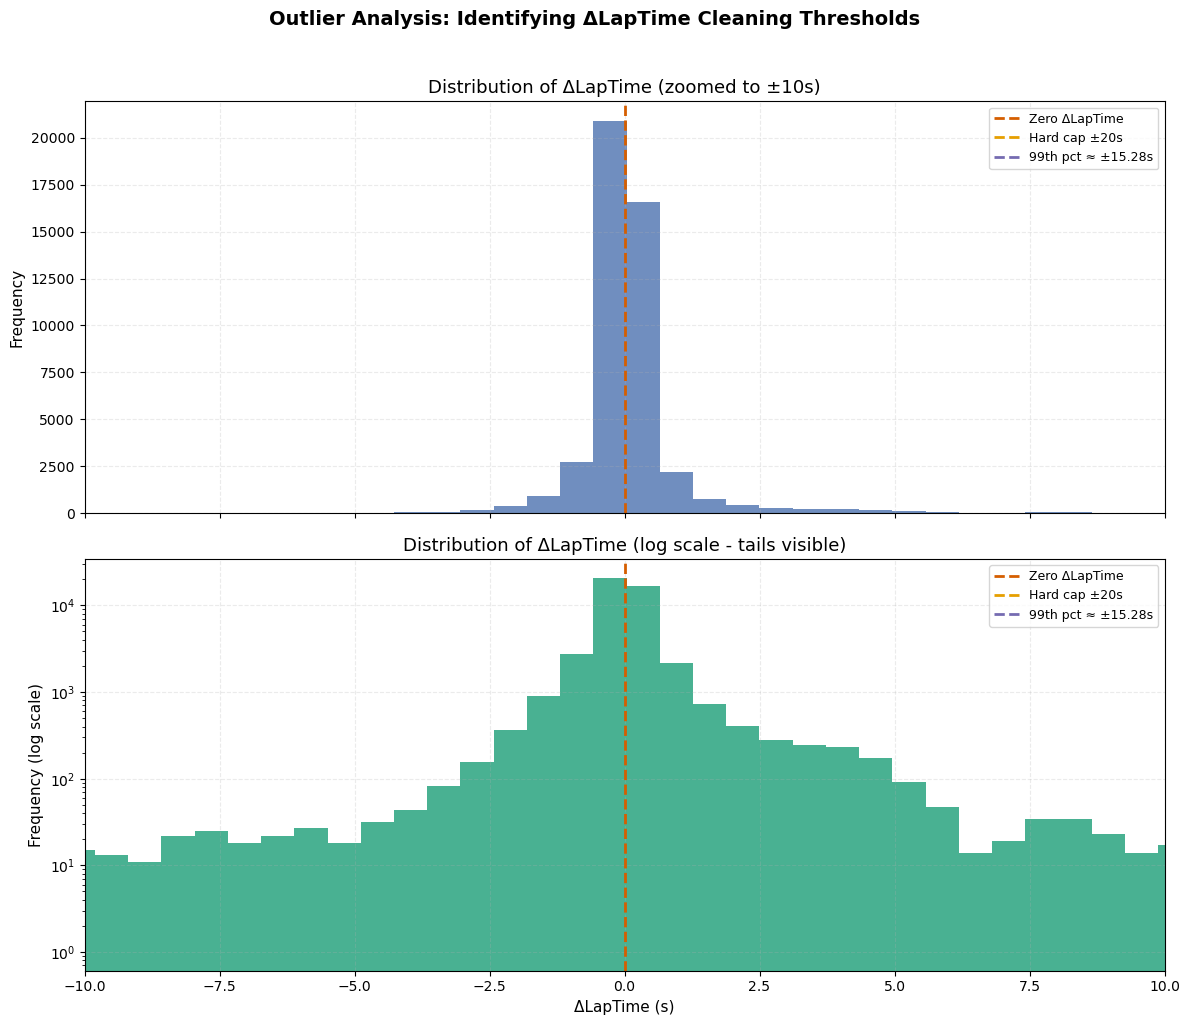


Removing extreme ΔLapTime outliers...
Stage 1 - Hard cap (|ΔLapTime| > 20s):
  Removed: 597 transitions (1.24%)
  Remaining: 47416

Stage 2 - 99th percentile trimming (|ΔLapTime| > 15.278s):
  Removed: 475 transitions (1.00%)
  Remaining: 46941

Total outlier removal:
  Original: 48013 transitions
  Removed: 1072 (2.23%)
  Final: 46941 transitions

ΔLapTime statistics (after outlier removal):
count    46941.000000
mean         0.110484
std          1.698402
min        -15.220000
25%         -0.228000
50%          0.001000
75%          0.244000
max         15.276000
Name: delta_laptime, dtype: float64


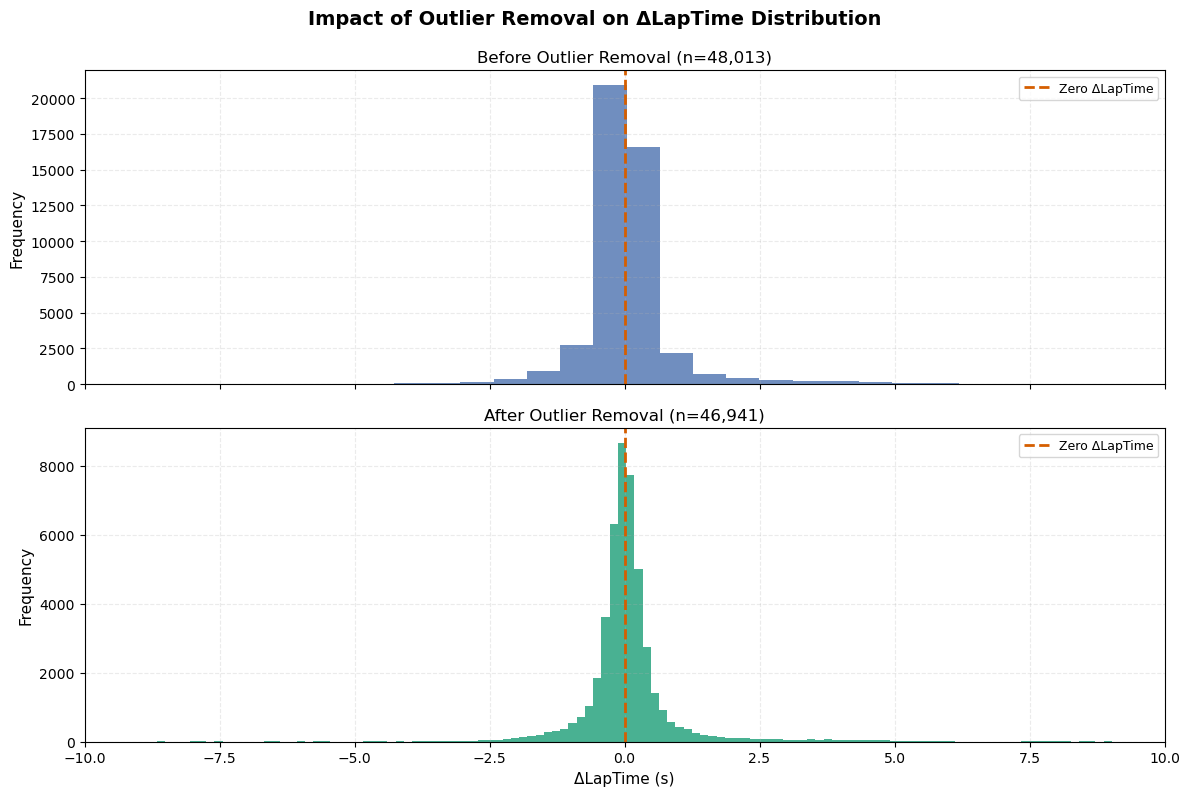

Final quantile cut used: 15.277699999999992


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def clean_and_plot_delta_laptime(
    df,
    delta_col="delta_laptime",
    hard_cap=20.0,
    quantile=0.99,
):
    """
    Clean ΔLapTime using a two-stage outlier procedure and produce
    report-quality diagnostic plots.

    Stage 1: Remove transitions with |ΔLapTime| > hard_cap  (e.g. spins, errors)
    Stage 2: Remove transitions above the given quantile (on the capped data)

    Returns
    -------
    df_clean : pd.DataFrame
        Data after outlier removal.
    q_threshold : float
        Absolute ΔLapTime value of the quantile cut on the capped data.
    """

    x = df[delta_col].dropna()
    print("Analyzing ΔLapTime distribution for outliers...")
    print("\nAbsolute |ΔLapTime| statistics:")
    print(x.abs().describe())

    # --- Compute quantile threshold on data within the hard cap (preview) ---
    x_capped = x[np.abs(x) <= hard_cap]
    q_threshold = x_capped.abs().quantile(quantile)
    print(f"\nPreview quantile (on |ΔLapTime| <= {hard_cap}s): "
          f"{quantile:.2%} at ±{q_threshold:.3f}s")

    # ============================================================
    # FIGURE 1: Outlier analysis & thresholds (2 plots)
    # ============================================================
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Palette (see section 3)
    color_raw = "#4C72B0"      # blue
    color_zero = "#D55E00"     # red/orange
    color_cap = "#E69F00"      # orange
    color_quant = "#756BB1"    # purple

    # 1A. Zoomed histogram (±10s)
    axes[0].hist(x, bins=200, color=color_raw, edgecolor="none", alpha=0.8)
    axes[0].axvline(0, color=color_zero, linestyle="--", linewidth=2,
                    label="Zero ΔLapTime")
    axes[0].axvline(+hard_cap, color=color_cap, linestyle="--", linewidth=2,
                    label=f"Hard cap ±{hard_cap:.0f}s")
    axes[0].axvline(-hard_cap, color=color_cap, linestyle="--", linewidth=2)
    axes[0].axvline(+q_threshold, color=color_quant, linestyle="--", linewidth=2,
                    label=f"{int(quantile*100)}th pct ≈ ±{q_threshold:.2f}s")
    axes[0].axvline(-q_threshold, color=color_quant, linestyle="--", linewidth=2)
    axes[0].set_xlim(-10, 10)
    axes[0].set_ylabel("Frequency", fontsize=11)
    axes[0].set_title("Distribution of ΔLapTime (zoomed to ±10s)", fontsize=13)
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.25, linestyle="--")

    # 1B. Log-scale histogram (full range)
    axes[1].hist(x, bins=200, color="#1B9E77", edgecolor="none", alpha=0.8)
    axes[1].axvline(0, color=color_zero, linestyle="--", linewidth=2,
                    label="Zero ΔLapTime")
    axes[1].axvline(+hard_cap, color=color_cap, linestyle="--", linewidth=2,
                    label=f"Hard cap ±{hard_cap:.0f}s")
    axes[1].axvline(-hard_cap, color=color_cap, linestyle="--", linewidth=2)
    axes[1].axvline(+q_threshold, color=color_quant, linestyle="--", linewidth=2,
                    label=f"{int(quantile*100)}th pct ≈ ±{q_threshold:.2f}s")
    axes[1].axvline(-q_threshold, color=color_quant, linestyle="--", linewidth=2)
    axes[1].set_xlabel("ΔLapTime (s)", fontsize=11)
    axes[1].set_ylabel("Frequency (log scale)", fontsize=11)
    axes[1].set_yscale("log")
    axes[1].set_title("Distribution of ΔLapTime (log scale - tails visible)",
                      fontsize=13)
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.25, linestyle="--")

    fig.suptitle("Outlier Analysis: Identifying ΔLapTime Cleaning Thresholds",
                 fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

    # ============================================================
    # Apply cleaning: hard cap + quantile trim
    # ============================================================
    print("\nRemoving extreme ΔLapTime outliers...")

    mask_cap = x.abs() <= hard_cap
    df_cap = df.loc[mask_cap].copy()
    removed_cap = len(df) - len(df_cap)

    print(f"Stage 1 - Hard cap (|ΔLapTime| > {hard_cap:.0f}s):")
    print(f"  Removed: {removed_cap} transitions "
          f"({100*removed_cap/len(df):.2f}%)")
    print(f"  Remaining: {len(df_cap)}")

    # recompute quantile on capped data (for reporting)
    q_threshold = df_cap[delta_col].abs().quantile(quantile)

    mask_quant = df_cap[delta_col].abs() <= q_threshold
    df_clean = df_cap.loc[mask_quant].copy()
    removed_quant = len(df_cap) - len(df_clean)

    print(f"\nStage 2 - {int(quantile*100)}th percentile trimming "
          f"(|ΔLapTime| > {q_threshold:.3f}s):")
    print(f"  Removed: {removed_quant} transitions "
          f"({100*removed_quant/len(df_cap):.2f}%)")
    print(f"  Remaining: {len(df_clean)}")

    total_removed = len(df) - len(df_clean)
    print(f"\nTotal outlier removal:")
    print(f"  Original: {len(df)} transitions")
    print(f"  Removed: {total_removed} "
          f"({100*total_removed/len(df):.2f}%)")
    print(f"  Final: {len(df_clean)} transitions")

    print("\nΔLapTime statistics (after outlier removal):")
    print(df_clean[delta_col].describe())

    # ============================================================
    # FIGURE 2: Before vs after cleaning (one key comparison)
    # ============================================================
    fig2, axes2 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # 2A. Before
    axes2[0].hist(df[delta_col], bins=200, color=color_raw,
                  edgecolor="none", alpha=0.8)
    axes2[0].axvline(0, color=color_zero, linestyle="--", linewidth=2,
                     label="Zero ΔLapTime")
    axes2[0].set_ylabel("Frequency", fontsize=11)
    axes2[0].set_title(f"Before Outlier Removal (n={len(df):,})", fontsize=12)
    axes2[0].legend(fontsize=9)
    axes2[0].grid(True, alpha=0.25, linestyle="--")
    axes2[0].set_xlim(-10, 10)

    # 2B. After
    axes2[1].hist(df_clean[delta_col], bins=200, color="#1B9E77",
                  edgecolor="none", alpha=0.8)
    axes2[1].axvline(0, color=color_zero, linestyle="--", linewidth=2,
                     label="Zero ΔLapTime")
    axes2[1].set_xlabel("ΔLapTime (s)", fontsize=11)
    axes2[1].set_ylabel("Frequency", fontsize=11)
    axes2[1].set_title(
        f"After Outlier Removal (n={len(df_clean):,})", fontsize=12
    )
    axes2[1].legend(fontsize=9)
    axes2[1].grid(True, alpha=0.25, linestyle="--")
    axes2[1].set_xlim(-10, 10)

    fig2.suptitle("Impact of Outlier Removal on ΔLapTime Distribution",
                  fontsize=14, fontweight="bold", y=0.99)
    plt.tight_layout()
    plt.show()

    return df_clean, float(q_threshold)

df_pairs_clean, q_cut = clean_and_plot_delta_laptime(
    df_pairs,
    delta_col="delta_laptime",
    hard_cap=20.0,
    quantile=0.99,
)
print("Final quantile cut used:", q_cut)


Sanity check: ΔLapTime by compound and stint progress...

Mean ΔLapTime by tyre compound:
                  mean       std  count
Compound                               
HARD          0.078660  1.616038  24243
INTERMEDIATE -0.502016  1.950755   1148
MEDIUM        0.158449  1.724471  17192
SOFT          0.263723  1.910662   4343
WET          -0.922400  3.168981     15

Mean ΔLapTime by stint progress:
                        mean       std  count
stint_progress_bin                           
0-20%              -0.135721  1.540106   4193
20-40%             -0.088679  1.393627   9603
40-60%              0.000391  0.928882  10726
60-80%             -0.012157  0.952150  10956
80-100%             0.587619  2.708496  11463


/var/folders/6f/l2mhfvbx40b0r05n911lr0fc0000gn/T/ipykernel_52344/3673773167.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  progress_stats = df_pairs.groupby("stint_progress_bin")["delta_laptime"].agg(['mean', 'std', 'count'])
/var/folders/6f/l2mhfvbx40b0r05n911lr0fc0000gn/T/ipykernel_52344/3673773167.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  progress_means = df_pairs.groupby("stint_progress_bin")["delta_laptime"].mean()


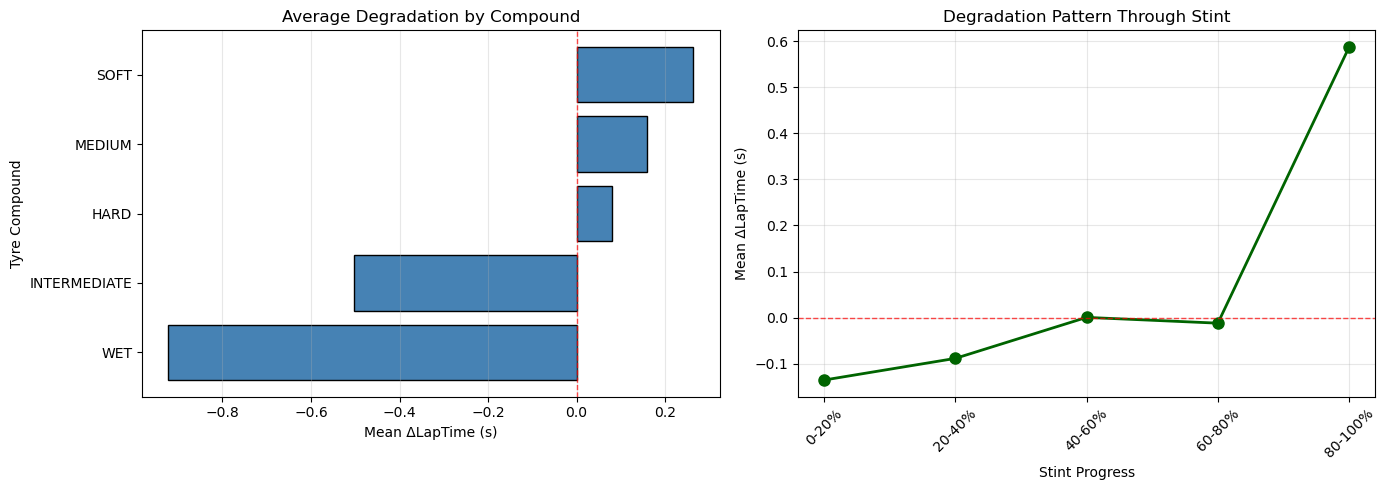


✓ Sanity check interpretation:
  - Early stint (0-20%): Laps may be faster (negative Δ) due to fuel burn-off
  - Mid-to-late stint (40-100%): Laps should get slower (positive Δ) due to degradation
  - Softer compounds (SOFT) should show more degradation than harder (HARD)


In [ ]:
########################################################
# STEP 2.D - SANITY CHECK: DELTAS BY COMPOUND AND STINT PROGRESS
########################################################


print("Sanity check: ΔLapTime by compound and stint progress")


# Check mean delta by compound
print("\nMean ΔLapTime by tyre compound:")
compound_stats = df_pairs.groupby("Compound")["delta_laptime"].agg(['mean', 'std', 'count'])
print(compound_stats)

# Create bins for stint progress
df_pairs['stint_progress_bin'] = pd.cut(
    df_pairs['rel_stint_progress'], 
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
)

print("\nMean ΔLapTime by stint progress:")
progress_stats = df_pairs.groupby("stint_progress_bin")["delta_laptime"].agg(['mean', 'std', 'count'])
print(progress_stats)

# Visualize degradation pattern
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Delta by compound
compound_means = df_pairs.groupby("Compound")["delta_laptime"].mean().sort_values()
axes[0].barh(compound_means.index, compound_means.values, color='steelblue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[0].set_xlabel("Mean ΔLapTime (s)")
axes[0].set_ylabel("Tyre Compound")
axes[0].set_title("Average Degradation by Compound")
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Delta by stint progress
progress_means = df_pairs.groupby("stint_progress_bin")["delta_laptime"].mean()
axes[1].plot(range(len(progress_means)), progress_means.values, 
             marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[1].set_xlabel("Stint Progress")
axes[1].set_ylabel("Mean ΔLapTime (s)")
axes[1].set_title("Degradation Pattern Through Stint")
axes[1].set_xticks(range(len(progress_means)))
axes[1].set_xticklabels(progress_means.index, rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Sanity check interpretation:")
print("  - Early stint (0-20%): Laps may be faster (negative Δ) due to fuel burn-off")
print("  - Mid-to-late stint (40-100%): Laps should get slower (positive Δ) due to degradation")
print("  - Softer compounds (SOFT) should show more degradation than harder (HARD)")



In [ ]:
########################################################
# STEP 2.E - RENAME COLUMNS FOR CLARITY
########################################################

print("\n" + "="*70)
print("Renaming columns for clarity (adding _s suffix for seconds)...")
print("="*70)

df_pairs = df_pairs.rename(columns={
    "LapTime": "LapTime_s",
    "LapTime_prev": "LapTime_prev_s",
    "delta_laptime": "delta_laptime_s"
})

print("Renamed columns:")
print("  LapTime → LapTime_s")
print("  LapTime_prev → LapTime_prev_s")
print("  delta_laptime → delta_laptime_s")

print("\n" + "="*70)
print("Degradation modeling dataset ready!")
print("="*70)
print(f"Final shape: {df_pairs.shape}")
print(f"Columns: {df_pairs.columns.tolist()}")
print("\nFirst few rows:")
df_pairs.head(10)

In [ ]:
import json, time
from urllib.request import urlopen
from urllib.error import HTTPError
import pandas as pd

def fetch_openf1_pit_for_years(
    years=(2023, 2024, 2025),               
    max_retries=3,
    base_delay=2,
    progress=True
):
    """
    Pulls OpenF1 pit events for all RACE sessions in the given years.
    No external helpers required.

    Returns
    -------
    pd.DataFrame
        One row per pit event with useful session/meeting metadata attached.
    """
    all_rows = []
    sessions_base = "https://api.openf1.org/v1/sessions"
    pit_base = "https://api.openf1.org/v1/pit"

    for y in years:
        # 1) discover RACE sessions for the year
        sess_url = f"{sessions_base}?year={y}&session_name=Race"
        if progress: print(f"\nYear {y}: fetching race sessions…", end=" ")

        with urlopen(sess_url) as resp:
            sessions = json.loads(resp.read().decode("utf-8"))

        if progress: print(f"{len(sessions)} sessions")

        # 2) for each session, fetch pits (with retries)
        for i, s in enumerate(sessions, 1):
            session_key = s.get("session_key")
            if not session_key:
                continue

            # prefer meeting_name; fall back to circuit short name
            gp_name = s.get("meeting_name") or s.get("circuit_short_name") or "UnknownGP"
            meeting_key = s.get("meeting_key")
            round_no = s.get("meeting_round") or s.get("meeting_official_name")

            url = f"{pit_base}?session_key={session_key}"
            if filters:
                url += "&" + (filters if isinstance(filters, str) else str(filters))

            for attempt in range(max_retries):
                try:
                    if progress:
                        print(f"  [{i}/{len(sessions)}] {gp_name} (session_key={session_key}) …", end=" ")

                    with urlopen(url) as resp:
                        data = json.loads(resp.read().decode("utf-8"))

                    # attach metadata
                    for row in data:
                        row["season_year"]     = y
                        row["grand_prix"]      = gp_name
                        row["race_session_key"]= session_key
                        row["meeting_key"]     = meeting_key
                        row["round"]           = round_no
                    all_rows.extend(data)

                    if progress: print(f"✓ {len(data)} rows")
                    time.sleep(base_delay)  # gentle on API
                    break

                except HTTPError as e:
                    if e.code == 429 and attempt < max_retries - 1:
                        wait = base_delay * (2 ** attempt)
                        if progress: print(f"429 rate limit → retry in {wait}s")
                        time.sleep(wait)
                        continue
                    else:
                        if progress: print(f"HTTP {e.code}: {e.reason}")
                        break
                except Exception as e:
                    if progress: print(f"Error: {e}")
                    break

    df = pd.DataFrame(all_rows)
    if not df.empty:
        # parse timestamp and order useful columns if present
        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
        preferred = [
            "season_year","round","grand_prix","race_session_key","meeting_key",
            "date","driver_number","lap_number","pit_duration"
        ]
        df = df[[c for c in preferred if c in df.columns] + [c for c in df.columns if c not in preferred]]

    return df

# --- Example usage ---
df_pits_23_25 = fetch_openf1_pit_for_years(years=(2023, 2024, 2025))
print(df_pits_23_25.shape)



Year 2023: fetching race sessions… 22 sessions
  [1/22] Sakhir (session_key=7953) … ✓ 0 rows
  [2/22] Jeddah (session_key=7779) … ✓ 0 rows
  [3/22] Melbourne (session_key=7787) … ✓ 0 rows
  [4/22] Baku (session_key=9070) … ✓ 0 rows
  [5/22] Miami (session_key=9078) … ✓ 0 rows
  [6/22] Monte Carlo (session_key=9094) … ✓ 0 rows
  [7/22] Catalunya (session_key=9102) … ✓ 43 rows
  [8/22] Montreal (session_key=9110) … ✓ 33 rows
  [9/22] Spielberg (session_key=9118) … ✓ 63 rows
  [10/22] Silverstone (session_key=9126) … ✓ 24 rows
  [11/22] Hungaroring (session_key=9133) … ✓ 36 rows
  [12/22] Spa-Francorchamps (session_key=9141) … ✓ 37 rows
  [13/22] Zandvoort (session_key=9149) … ✓ 101 rows
  [14/22] Monza (session_key=9157) … ✓ 25 rows
  [15/22] Singapore (session_key=9165) … ✓ 25 rows
  [16/22] Suzuka (session_key=9173) … ✓ 43 rows
  [17/22] Lusail (session_key=9221) … ✓ 54 rows
  [18/22] Austin (session_key=9213) … ✓ 36 rows
  [19/22] Mexico City (session_key=9181) … ✓ 38 rows
  [20/22] 

In [43]:
# drop columns round , race_session_key , meeting_key , date , pit_duration , session_key
df_pits_23_25 = df_pits_23_25.drop(columns=[
    "round", "race_session_key", "meeting_key", "date", "pit_duration", "session_key"
], errors='ignore')

df_pits_23_25.to_csv("csv_output/openf1_pit_2023_2025.csv", index=False)

df_pits_23_25.head()

,season_year,grand_prix,driver_number,lap_number
0,2023,Catalunya,4,1.0
1,2023,Catalunya,77,5.0
2,2023,Catalunya,27,8.0
3,2023,Catalunya,24,9.0
4,2023,Catalunya,21,9.0
